# Introduction to text classification

This workshop is a one-hour beginner's introduction to text classification. 

This notebook deliberately has more content that we can reasonably cover in one hour. To get the most out of this workshop, I'd suggest spending some time working through it in full after the workshop.

We'll cover the following topics:

[What is text classification?](#what)

_What is text classification and why should you care?_

[Exploratory Data Analysis](#eda)

_It's always a good idea to get to know your data before doing anything else._

[Featurization](#featurization)

_How can we turn natural language data into something we can do machine learning on?_

[Classification](#classification)

_How can a computer learn to distinguish between different categories?_

[Interpretation](#interpret)

_Did the computer learn correctly? Can the computer tell us anything new about our data?_

## What is text classification?<a id='what'></a>

Imagine that you work at [YouTube](https://www.youtube.com/) (if you haven't heard of it, YouTube is a video-sharing website). Your job is to remove comments on videos that are spam (unsolicited and inappropriate comments). You look through each video and read the comments yourself, deciding which are spam and which are not spam. Perhaps you see comments like those below. Which would you consider to be spam and which not spam?

- _Hey @dancer317, love ur videos so much! Thanks for all the tips on dancing!_
- _OUR  LASER PRINTER/FAX/COPIER TONER CARTRIDGE PRICES NOW AS LOW AS 39 DOLLARS. SPECIALS WEEKLY ON ALL LASER PRINTER SUPPLIES. WE CARRY MOST ALL LASER PRINTER CARTRIDGES, FAX SUPPLIES AND COPIER TONERS AT WAREHOUSE PRICES_
- _I'm not sold on your first point about crossing national boundaries, but I see what you mean about non-economic alternatives._
- _Some of the most beautiful women in the world bare it all for you. Denise Richards, Britney  Spears, Jessica Simpson, and many more. CLICK HERE FOR NUDE CELEBS_

How did you decide which were spam and which weren't? Maybe one thing you noted was the high number of words in all capitals. The topics can also give you a clue, as the spam-like comments talk about selling things and nudity, which are often found in spam comments.

However you decided, we can think about the task you were doing like this:

<img src='img/human-classification.jpg' />

This is text classification, performed by a human. What you just did was an example of text classification. You took a comment written in English, and you classified it into one of two classes: spam or not spam. Wouldn't it be nice to have a computer do this for you? [You could outsource your job to the computer and just surf the web all day](https://www.npr.org/sections/thetwo-way/2013/01/16/169528579/outsourced-employee-sends-own-job-to-china-surfs-web). What you'd want to do is replace the human with a computer, like this:


<img src='img/computer-classification.jpg' />

How are we going to do this? Well, what if, for each comment on YouTube, we counted the number of times it mentioned nudity or tried to sell something, and we measured the proportion of capital letters? We'd get two numbers for each comment. We could also use your human judgements from before in a third column telling us whether that comment is spam or not.

| Comment                                                 | Selling or nudity | Proportion capital letters | Is it spam? |
|---------------------------------------------------------|-------------------|----------------------------|-------------|
| Hey @dancer317, love ur videos so much! Thanks for ...  | 0                 | 0.1                        | No          |
| OUR LASER PRINTER/FAX/COPIER TONER CARTRIDGE PRICES ... | 4                 | 1.0                        | Yes         |
| I'm not sold on your first point ...                    | 1                 | 0.05                       | No          |
|  Some of the most beautiful women in the world ...      | 3                 | 0.15                       | Yes         |

We can treat these two numbers as geometric coordinates and plot them. We can plot the spam comments in red and the non-spam comments in green.

<img src='img/classification-no-line.jpg' />

<img src='img/classification-with-line.jpg' />

**To do text classification, we're going to need to do two things:**
- **Turn our natural language comments into numbers.**
- **Train a classifier to take those numbers and distinguish between the classes.**

Why do we care about text classification? Because most applied natural language processing problems can be tackled as text classification:

- Sentiment analysis
- Genre classification
- Language identification
- Authorship attribution
- Is this document relevant to this legal case?
- Is the patient in need of urgent care?

### What is sentiment analysis?

In this notebook, we're going to perform [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) on a dataset of tweets about US airlines. Sentiment analysis is the task of extracting [affective states][1] from text. Sentiment analysis is most ofen used to answer questions like:

[1]: https://en.wikipedia.org/wiki/Affect_(psychology)

- _what do our customers think of us?_
- _do our users like the look of our product?_
- _what aspects of our service are users dissatisfied with?_

### Dataset

The dataset was collected by [Crowdflower](https://www.crowdflower.com/), which they then made public through [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). I've downloaded it for you and put it in the "data" directory. Note that this is a nice clean dataset; not the norm in real-life data science! I've chosen this dataset so that we can concentrate on understanding what text classification is and how to do it.

In [1]:
%matplotlib inline
import os
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
sns.set()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Exploratory Data Analysis<a id='eda'></a>

In [2]:
DATA_DIR = 'data'
fname = os.path.join(DATA_DIR, 'tweets.csv')
df = pd.read_csv(fname)
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


Which airlines are tweeted about and how many of each in this dataset?

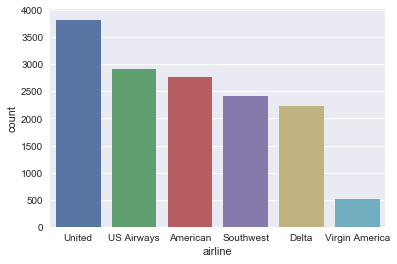

In [3]:
sns.countplot(df['airline'], order=df['airline'].value_counts().index);

### Challenge

- How many tweets are in the dataset?
- How many tweets are positive, neutral and negative?
- What **proportion** of tweets are positive, neutral and negative?
- Visualize these last two questions.

In [4]:
# solution
print("Length is", len(df))

Length is 14640


In [5]:
# solution
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [6]:
# solution
df['airline_sentiment'].value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

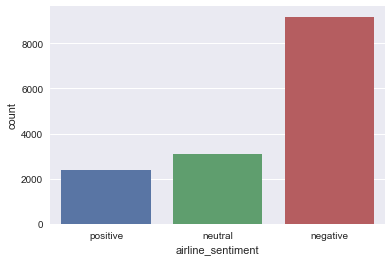

In [7]:
# solution
sns.countplot(df['airline_sentiment'], order=['positive', 'neutral', 'negative']);

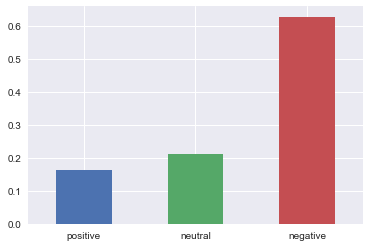

In [8]:
# solution
df['airline_sentiment'].value_counts(normalize=True, ascending=True).plot(kind='bar', rot=0);

### Extra challenge

- When did the tweets come from?
- Who gets more retweets: positive, negative or neutral tweets?
- What are the three main reasons why people are tweeting negatively? What could airline companies do to improve this?
- What's the distribution of time zones in which people are tweeting?
- Is this distribution consistent depending on what airlines they're tweeting about?

**All the tweets in this dataset came from the third week of February 2015.**

In [9]:
# solution
dates = pd.to_datetime(df['tweet_created'])
print("Year:\n")
print(dates.dt.year.value_counts())
print("Month:\n")
print(dates.dt.month.value_counts())
print("Day:\n")
print(dates.dt.day.value_counts())

Year:

2015    14640
Name: tweet_created, dtype: int64
Month:

2    14640
Name: tweet_created, dtype: int64
Day:

23    3515
22    2392
24    2136
20    1512
21    1418
18    1416
19    1298
17     953
Name: tweet_created, dtype: int64


We don't see any interesting evidence of tweets of different classes getting more or less retweets. The vast majority of tweets from all three classes get no retweets.

In [10]:
# solution
df.groupby('airline_sentiment')['retweet_count'].describe()

,count,mean,std,min,25%,50%,75%,max
airline_sentiment,,,,,,,,
negative,9178.0,0.093375,0.792865,0.0,0.0,0.0,0.0,44.0
neutral,3099.0,0.060987,0.658037,0.0,0.0,0.0,0.0,28.0
positive,2363.0,0.069403,0.659914,0.0,0.0,0.0,0.0,22.0


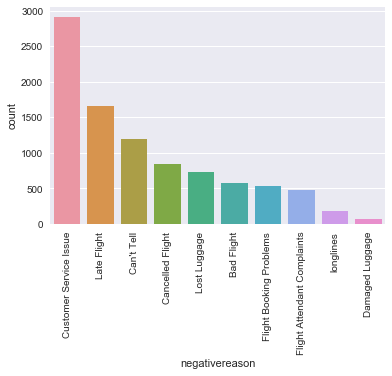

In [11]:
# solution
sns.countplot(df['negativereason'], order=df['negativereason'].value_counts().index)
plt.xticks(rotation=90);

## Featurization<a id='featurization'></a>

How are we going to turn our tweets into numbers? Well first, I want to do some quick preprocessing to remove some junk:

In [12]:
twitter_handle_pattern = r'@(\w+)'
hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
url_pattern = r'https?:\/\/.*.com'

def clean_tweets(tweets):
    tweets = [re.sub(hashtag_pattern, ' HASHTAG', t) for t in tweets]
    tweets = [re.sub(twitter_handle_pattern, 'USER', t) for t in tweets]
    return [re.sub(url_pattern, 'URL', t) for t in tweets]

my_tweets = ["lol @justinbeiber and @BillGates are like soo #yesterday #amiright saw it on https://twitter.com #yolo",
            'omg I am never flying on Delta again',
            'I love @VirginAmerica so much #friendlystaff']

clean_tweets(my_tweets)

['lol USER and USER are like soo HASHTAG HASHTAG saw it on URL HASHTAG',
 'omg I am never flying on Delta again',
 'I love USER so much HASHTAG']

In [13]:
df['clean_text'] = (df['text']
                    .str.replace(hashtag_pattern, 'HASHTAG')
                    .str.replace(twitter_handle_pattern, 'USER')
                    .str.replace(url_pattern, 'URL')
                              )
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),USER What USER said.
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),USER plus you've added commercials to the expe...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),USER I didn't today... Must mean I need to tak...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),USER it's really aggressive to blast obnoxious...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),USER and it's a really big bad thing about it


### Bag of words

Now that we've cleaned the text, we need to turn the text into numbers for our classifier. We're going to use a "bag of words" as our features. A bag of words is just like a frequency count of all the words that appear in a tweet. It's called a bag because we ignore the order of the words; we just care about what words are in the tweet. To do this, we can use `scikit-learn`'s `CountVectorizer`. `CountVectorizer` replaces each tweet with a vector (think a list) of counts. Each position in the vector represents a unique word in the corpus. The value of an entry in a vector represents the number of times that word appeared in that tweet. Below, we restrict the length of the vectors to be 5,000 and the counts to be 0 (not in the tweet) and 1 (in the tweet).

In [14]:
countvectorizer = CountVectorizer(max_features=5000, binary=True)
X = countvectorizer.fit_transform(df['clean_text'])
features = X.toarray()
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [15]:
response = df['airline_sentiment'].values
response

array(['neutral', 'positive', 'neutral', ..., 'neutral', 'negative',
       'neutral'], dtype=object)

### Split into train/test datasets

We don't want to train our classifier on the same dataset that we test it on, so let's split it into training and test sets.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2)

## Classification  <a id='classification'></a>

OK, so now that we've turned our data into numbers, we're ready to feed it into a classifier. We're not going to concentrate too much on the code below, but here's the big picture. In the `fit_model` function defined below, we're going to use logistic regression as a classifier to take in the numerical representation of the tweets and spit out whether it's positive, neutral or negative. Then we'll use `test_model` to test the model's performance against our test data and print out some results.

In [17]:
def fit_logistic_regression(X_train, y_train):
    model = LogisticRegressionCV(Cs=5, penalty='l1', cv=3, solver='liblinear', refit=True)
    model.fit(X_train, y_train)
    return model

def conmat(model, X_test, y_test):
    """Wrapper for sklearn's confusion matrix."""
    labels = model.classes_
    y_pred = model.predict(X_test)
    c = confusion_matrix(y_test, y_pred)
    sns.heatmap(c, annot=True, fmt='d', 
                xticklabels=labels, 
                yticklabels=labels, 
                cmap="YlGnBu", cbar=False)
    plt.ylabel('Ground truth')
    plt.xlabel('Prediction')
    
def test_model(model, X_train, y_train):
    conmat(model, X_test, y_test)
    print('Accuracy: ', model.score(X_test, y_test))

In [18]:
lr = fit_logistic_regression(X_train, y_train)

Accuracy:  0.805327868852459


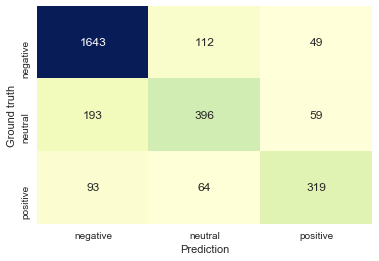

In [19]:
test_model(lr, X_test, y_test)

### Challenge

Use the `fit_random_forest` function below to train a random forest classifier on the training set and test the model on the test set. Which performs better?

In [20]:
def fit_random_forest(X_train, y_train):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model

Accuracy:  0.7414617486338798


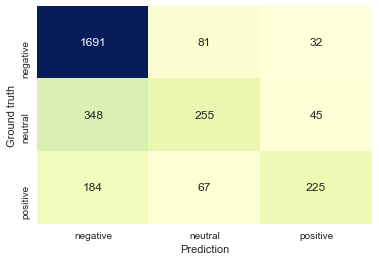

In [21]:
# solution
rf = fit_random_forest(X_train, y_train)
test_model(rf, X_test, y_test)

### Challenge

Use the `test_tweet` function below to test your classifier's performance on a list of tweets. Write your tweets 

In [22]:
def clean_tweets(tweets):
    tweets = [re.sub(hashtag_pattern, ' HASHTAG', t) for t in tweets]
    tweets = [re.sub(twitter_handle_pattern, 'USER', t) for t in tweets]
    return [re.sub(url_pattern, 'URL', t) for t in tweets]

def test_tweets(tweets, model):
    tweets = clean_tweets(tweets)
    features = countvectorizer.transform(tweets)
    predictions = model.predict(features)
    return list(zip(tweets, predictions))

In [23]:
# solution
my_tweets = ["lol @justinbeiber and @BillGates are like soo #yesterday #amiright saw it on https://twitter.com #yolo",
            'omg I am never flying on Delta again',
            'I love @VirginAmerica so much #friendlystaff']

test_tweets(my_tweets, lr)

[('lol USER and USER are like soo HASHTAG HASHTAG saw it on URL HASHTAG',
  'neutral'),
 ('omg I am never flying on Delta again', 'negative'),
 ('I love USER so much HASHTAG', 'positive')]

## Interpret <a id='interpret'></a>

Now we can interpret the classifier by the features that it found important.

In [24]:
vocab = [(v,k) for k,v in countvectorizer.vocabulary_.items()]
vocab = sorted(vocab, key=lambda x: x[0])
vocab = [word for num,word in vocab]
coef = list(zip(vocab, lr.coef_[0]))
important = pd.DataFrame(lr.coef_).T
important.columns = lr.classes_
important['word'] = vocab

In [25]:
important.sort_values(by='negative', ascending=False).head(10)

,negative,neutral,positive,word
4946,4.964530,-2.968088,-3.294442,worst
4489,3.331741,-0.843596,-0.944500,third
4728,2.919172,-0.085944,-0.007325,unless
3787,2.867997,-2.220034,-0.722136,ridiculous
4449,2.712353,-1.538292,-1.787034,terrible
509,2.680487,-1.033508,-0.625724,alternate
4338,2.639722,-1.549369,-1.465791,sucks
32,2.601016,-1.019397,0.000000,140
1927,2.574252,-1.348797,-0.788616,forced
3917,2.564091,0.000000,-2.122057,screwed


In [26]:
important.sort_values(by='positive', ascending=False).head(10)

,negative,neutral,positive,word
4943,-3.807955,0.000000,4.271496,worries
1680,-2.042055,-1.464192,4.088187,excellent
3396,-2.238108,0.000000,3.882890,pleasure
2620,-1.874195,-0.466127,3.604312,kudos
4462,-2.593646,-1.304508,3.432240,thank
711,-2.232277,-1.841948,3.316700,awesome
1683,-2.061644,0.000000,3.227271,exceptional
4929,-2.188021,-0.709158,3.120052,wonderful
518,-2.387029,-0.792597,3.021397,amazing
4465,-1.838381,-1.213982,2.923657,thanks
